In [1]:
import numpy as np 
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import cv2

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from myvtk.srv import square_root_velocity

from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from procrustes import rotational
import pandas as pd

files = glob.glob("./scaling/resamp_attr_ascii/vmtk64a/*.vtk")

#########################################
#    vmtkで計算したcurv, torsを使う      #
#       0.5mmまでresamplingした         # 
#########################################
# files = (glob.glob(".\\scaling\\resamp_attr_ascii\\vmtkgeometry\\*.vtk"))


r = []
pts = []
PTN = []
curvs = []
torss = []
abscs = [] 
Tangents = []
for i in range(len(files)): 
    pt, Curv, Tors, Radius, Abscissas, ptns, ftangent = GetMyVtk(files[i], frenetTangents=1)
    if len(pt) != 64:
        print (len(pt), files[i])
        continue
    centroid = np.array([np.mean(pt[:,0]),np.mean(pt[:,1]),np.mean(pt[:,2])])
    pt = pt-centroid
    pts.append(pt)
    r.append(Radius)
    PTN.append(ptns)
    curvs.append(Curv)
    torss.append(Tors)
    abscs.append(Abscissas)
    Tangents.append(ftangent)
pts = np.array(pts)
r = np.array(r)
PTN = np.array(PTN)
curvs=np.array(curvs)
torss = np.array(torss)
abscs= np.array(abscs)
Tangents = np.array(Tangents)

print (Tangents.shape)
print (PTN.shape)

(104, 64, 3)
(104, 64, 3)


In [2]:

# v1 = 0
# v2 = 0
# aligned_pts = []
# aligned_pts.append(new_pts[0,:,:])
# for i in range(1, len(new_pts)):
#     result_rot = rotational(new_pts[i,:,:], new_pts[0,:,:], translate=False, scale=False)
#     # aligned_pts.append(result_rot.new_a)
#     aligned_pts.append(np.dot(result_rot.new_a, result_rot.t))
#     scalarAttribute= [['MaximumInscribedSphereRadius', 'float', r[i]]]
#     # makeVtkFile(savePath = "D:\\!BraVa_src\\src\\ModeDecomposition\\rot_alignment\\"+files[i].split("\\")[-1],
#     #             coords = np.dot(result_rot.new_a, result_rot.t),
#     #             scalarAttributes=scalarAttribute,
#     #             fieldAttributes=[] )



# aligned_pts = np.array(aligned_pts)

In [3]:
feature = np.load('./CUSV/srvr_feature.npy')
print (feature.shape)

(104, 16)


In [4]:
Height = -0.9855
for idx in range(len(files)):
    filename  =  files[idx].split("\\")[-1][:-12]
    k1k2file = "./k1k2/{}.csv".format(filename)
    df = pd.read_csv(k1k2file, index_col=False)
    df.columns = ['idx','x_k1','x_k2','y_k1','y_k2','z_k1', 'z_k2']

    temp_pts = pts[idx]
    temp_ptn = PTN[idx]
    temp_tangent = Tangents[idx]
    temp_curv = curvs[idx]
    d_tangent = []

    for nd_idx in range(1, len(temp_pts)):
        # print (nd_idx)
        d_tangent.append(np.dot(temp_tangent[nd_idx-1],temp_tangent[nd_idx]))
    d_tangent=np.array(d_tangent)
    peaks = find_peaks(-d_tangent, distance=6, width=1, height=Height)[0]

    fig = plt.figure(dpi=140,figsize=(12,5))
    fig.suptitle("{}, Height:{}".format(filename, round(Height,4)), fontsize=10)
    gs = fig.add_gridspec(nrows=22, ncols=45)
    ax = fig.add_subplot(gs[:10, :20])
    ax2 = fig.add_subplot(gs[12:, :20])
    ax3 = fig.add_subplot(gs[:, 26:])
    ax3.scatter(feature[:,0], feature[:,1], color="dimgray", alpha=0.3)
    ax3.scatter(feature[idx,0], feature[idx,1], color="black", alpha=1.)
    ax3.set_xlabel("PC1",fontsize=10)
    ax3.set_ylabel("PC2",fontsize=10)
    ax3.grid(linestyle=":")
    ax3.set_title("SRVR PCA")

    ax1 = ax.twinx()
    ax.set_ylim(0,1.1)
    ax1.set_ylim(-15,15)
    lns1 =ax.plot(d_tangent, label="tangent dot", color="black")
    lns2 =ax1.plot(temp_pts[:,2],linestyle="--",label="coord", color="black")
    for p in peaks:
        ax.scatter(p, d_tangent[p], color="white", edgecolors="black", marker="s")
        ax.text(p, d_tangent[p], -round(d_tangent[p], 3))
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax2.plot(temp_curv,label="curvature", color="black")
    ax2.set_ylim(0,1)
    ax2.legend()
    # plt.tight_layout()
    plt.savefig("./CUSV/{}.png".format(filename))
    plt.close()

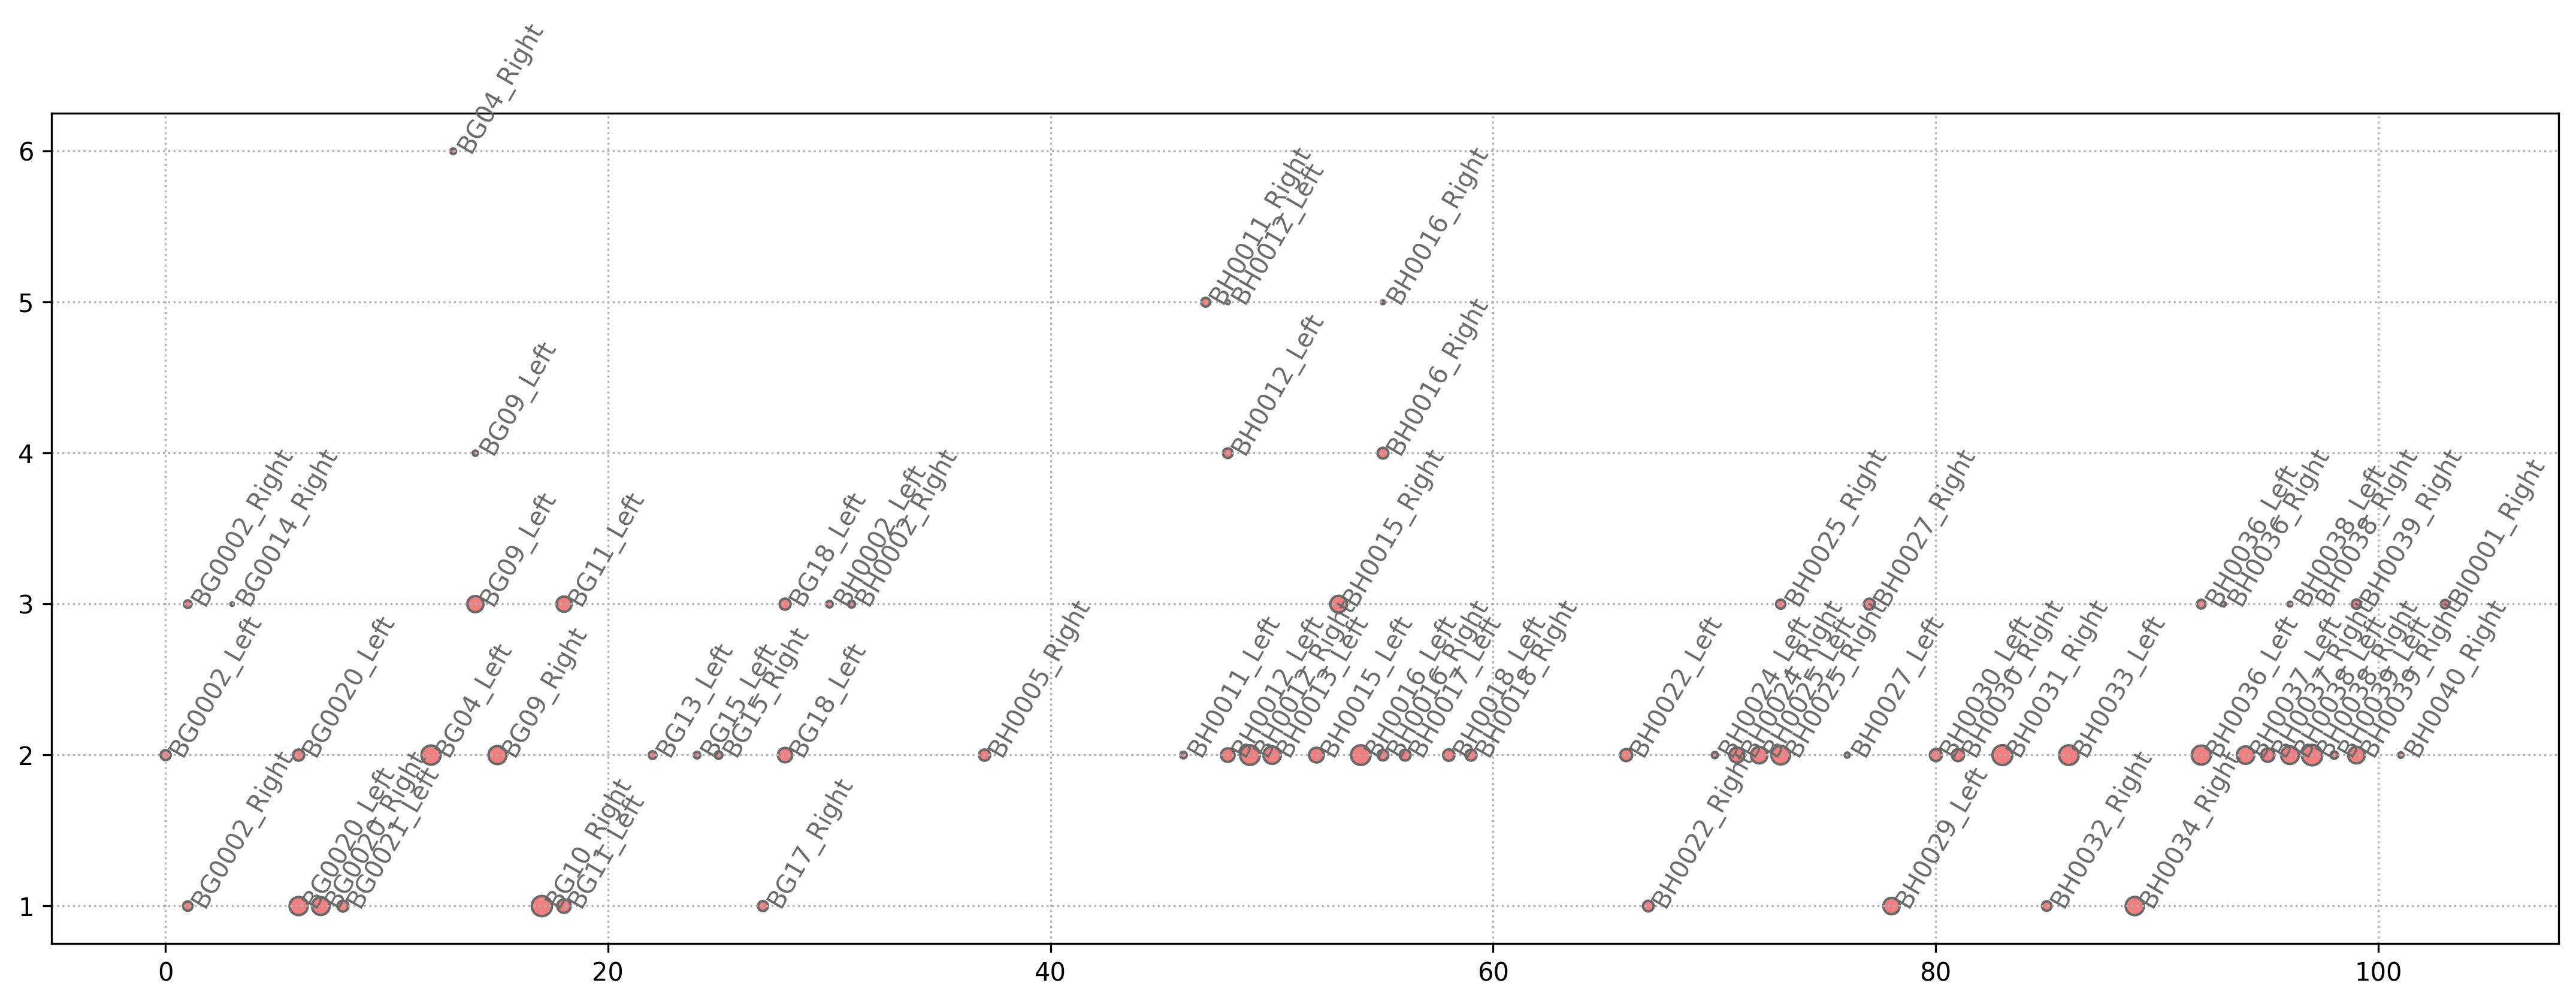

In [44]:
import matplotlib
cmap = matplotlib.cm.get_cmap("rainbow")
fig = plt.figure(dpi=300,figsize=(18,6))
ax=fig.add_subplot(111)

idx_buff = []
bool_peaks = []
for idx in range(len(files)):
    bool_peak = np.zeros(64)
    filename  =  files[idx].split("\\")[-1][:-12]
    # print (filename)
    k1k2file = "./k1k2/{}.csv".format(filename)
    df = pd.read_csv(k1k2file, index_col=False)
    df.columns = ['idx','x_k1','x_k2','y_k1','y_k2','z_k1', 'z_k2']
    temp_pts = pts[idx]
    temp_ptn = PTN[idx]
    temp_tangent = Tangents[idx]
    temp_curv = curvs[idx]
    d_tangent = []

    for nd_idx in range(1, len(temp_pts)):
        # print (nd_idx)
        d_tangent.append(np.dot(temp_tangent[nd_idx-1],temp_tangent[nd_idx]))
    d_tangent=np.array(d_tangent)
    peaks = find_peaks(-d_tangent, distance=5, width=1, height=Height)[0]
    average_ptn = np.zeros(3)
    bends = []
    for p in range(1, len(peaks)):
        previous_p = peaks[p-1]
        current_p = peaks[p]
        segment = temp_ptn[previous_p:current_p]
        # print (segment.shape)
        for s in segment:
            average_ptn = average_ptn + (s)
        average_ptn = average_ptn/len(segment)
        # print (average_ptn.shape)
        bends.append(average_ptn)
    
    for b in range(1, len(bends)):
        if np.dot(bends[b-1], bends[b])<0.2:
            bool_peak[peaks[b]] = 1
            plt.scatter(idx, b, color="lightcoral", edgecolors="dimgray", s=abs(np.dot(bends[b-1], bends[b]))*100)
            plt.text(idx, b, filename, rotation=60,color="dimgray")
            idx_buff.append(idx)
    bool_peaks.append(bool_peak)
plt.grid(linestyle=":")

idx_buff = list(set(idx_buff))

(104, 64)


C:\Users\cheno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 1000x1000 with 0 Axes>

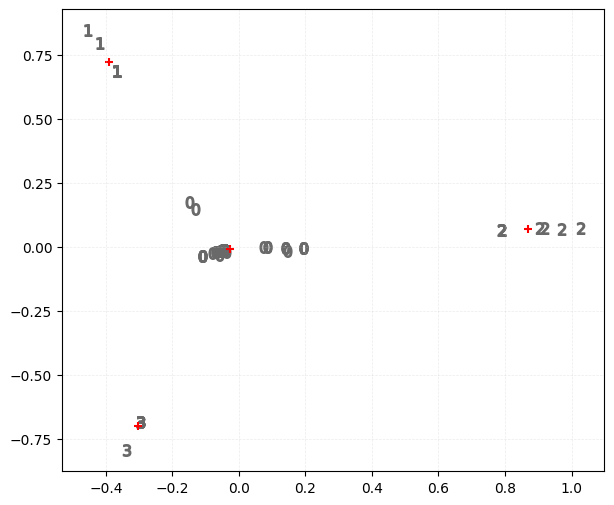

In [23]:
bool_peaks = np.array(bool_peaks)
print (bool_peaks.shape)

pca = PCA(n_components=2)
result = pca.fit_transform(bool_peaks)
fig = plt.figure(figsize=(10,10))


from sklearn.cluster import KMeans
from scipy import optimize
from math import sqrt


#Initialize the class object
kmeans = KMeans(n_clusters= 4)
 
#predict the labels of clusters.
label = kmeans.fit_predict(result)
 
#Getting unique labels
u_labels = np.unique(label)


#plotting the results:
plt.figure(figsize=(7,6))
# for idx in range(len(files)):
#     bool_peak = np.zeros(64)
#     filename  =  files[idx].split("\\")[-1][:-12]
#     if idx in idx_buff:
#         plt.scatter(result[idx, 0] , result[idx, 1] , 
#                 label = i, 
#                 color='red', 
#                 s=70)


for i in u_labels:
    plt.scatter(result[label == i , 0] , result[label == i , 1] , 
                label = i, 
                color='dimgray', 
                s=70,
                marker="${}$".format(i))
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='red',marker='+',label='centroid')
plt.grid(color = 'silver', linestyle = '--', linewidth = 0.5,alpha=0.3)
# plt.legend()
# plt.savefig('cluster.png')
plt.show()

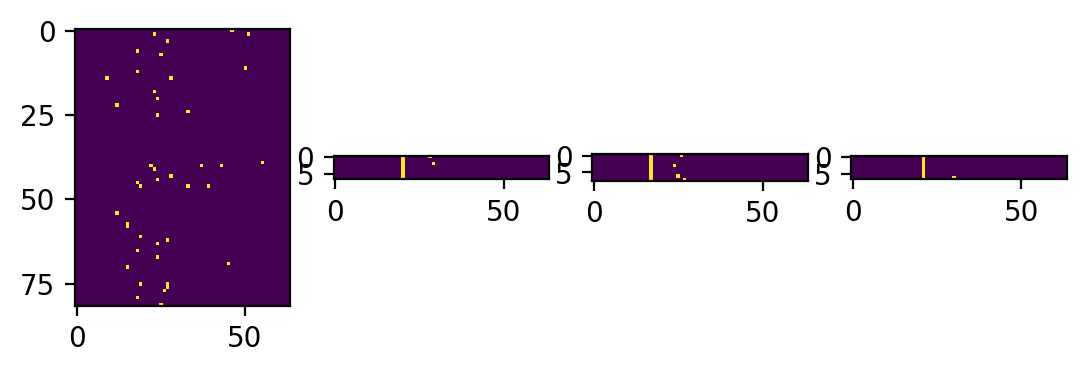

In [42]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.imshow(bool_peaks[label==0])
ax2.imshow(bool_peaks[label==1])
ax3.imshow(bool_peaks[label==2])
ax4.imshow(bool_peaks[label==3])
    

需要开发一个评分体系来评价一个形状的likelihood

In [30]:
from collections import Counter
label_sorted = list(Counter(label))


labeldict = {
    label_sorted[0]:"mass",
    label_sorted[1]:"type1",
    label_sorted[2]:"type2",
    label_sorted[3]:"type3"
}

print (labeldict)

{0: 'mass', 2: 'type1', 3: 'type2', 1: 'type3'}


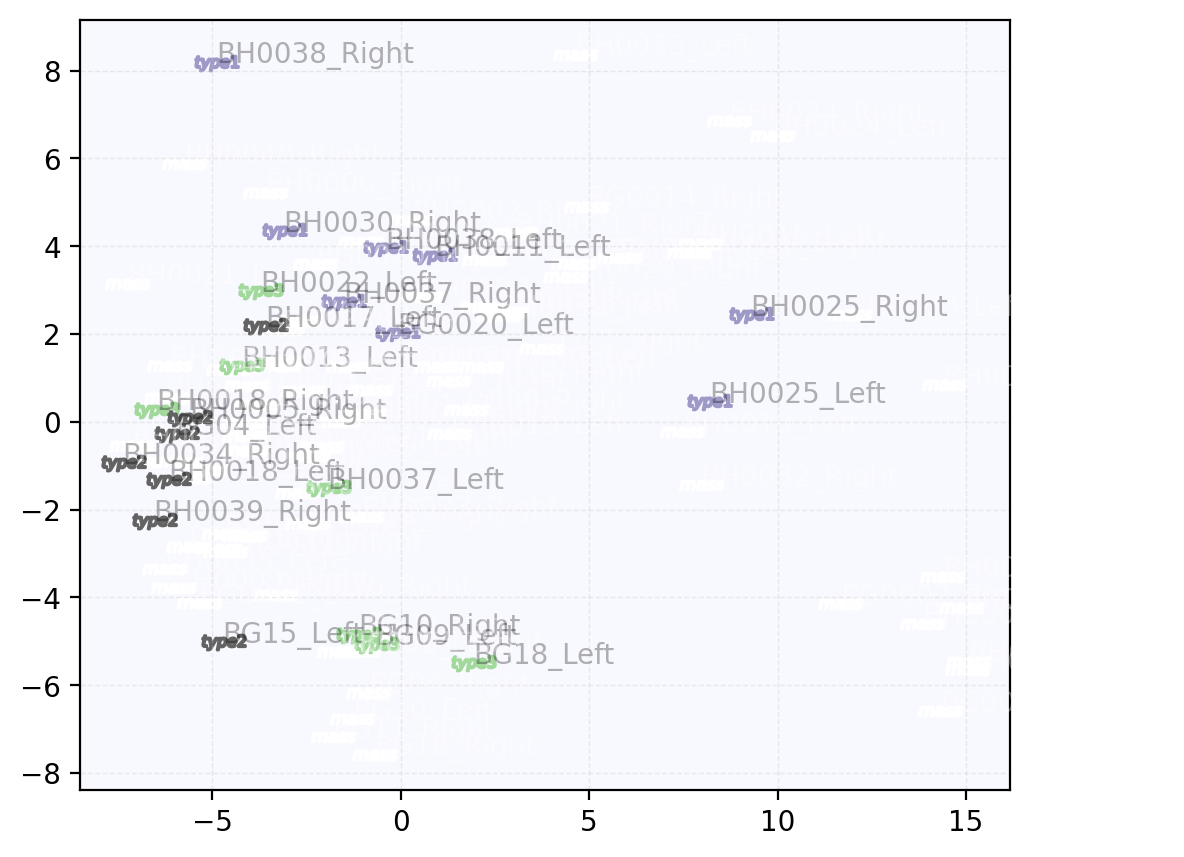

In [33]:


#plotting the results:
cmap=matplotlib.cm.get_cmap("tab20c")
fig = plt.figure(dpi=200,figsize=(6,5))
ax = fig.add_subplot(111)
pc_x = 1
pc_y = 2
for i in u_labels:
    if labeldict[i] == "mass":
        color="white"
        # color=cmap((i+2)/(len(u_labels)+2)), 
    else:
        color=cmap((i+2)/(len(u_labels)+2)), 

    ax.scatter(feature[label == i , pc_x] , feature[label == i , pc_y] , 
                label = i, 
                color=color, 
                s=250,
                marker="${}$".format(labeldict[i]))
for i in range(len(files)):
    # print (files[i])
    # if "BH0021" in files[i]:
    if label[i] == 0:
        color="white"
    else:
        color ="black"

    ax.text(feature[i , pc_x] , feature[i, pc_y] , 
               s = files[i].split("\\")[-1][:-12], 
               color=color,
               alpha=0.3)
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='dimgray',marker='+',label='centroid')
ax.grid(color = 'silver', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax.set_facecolor("ghostwhite")
# plt.legend()
# plt.savefig('cluster.png')
plt.show()


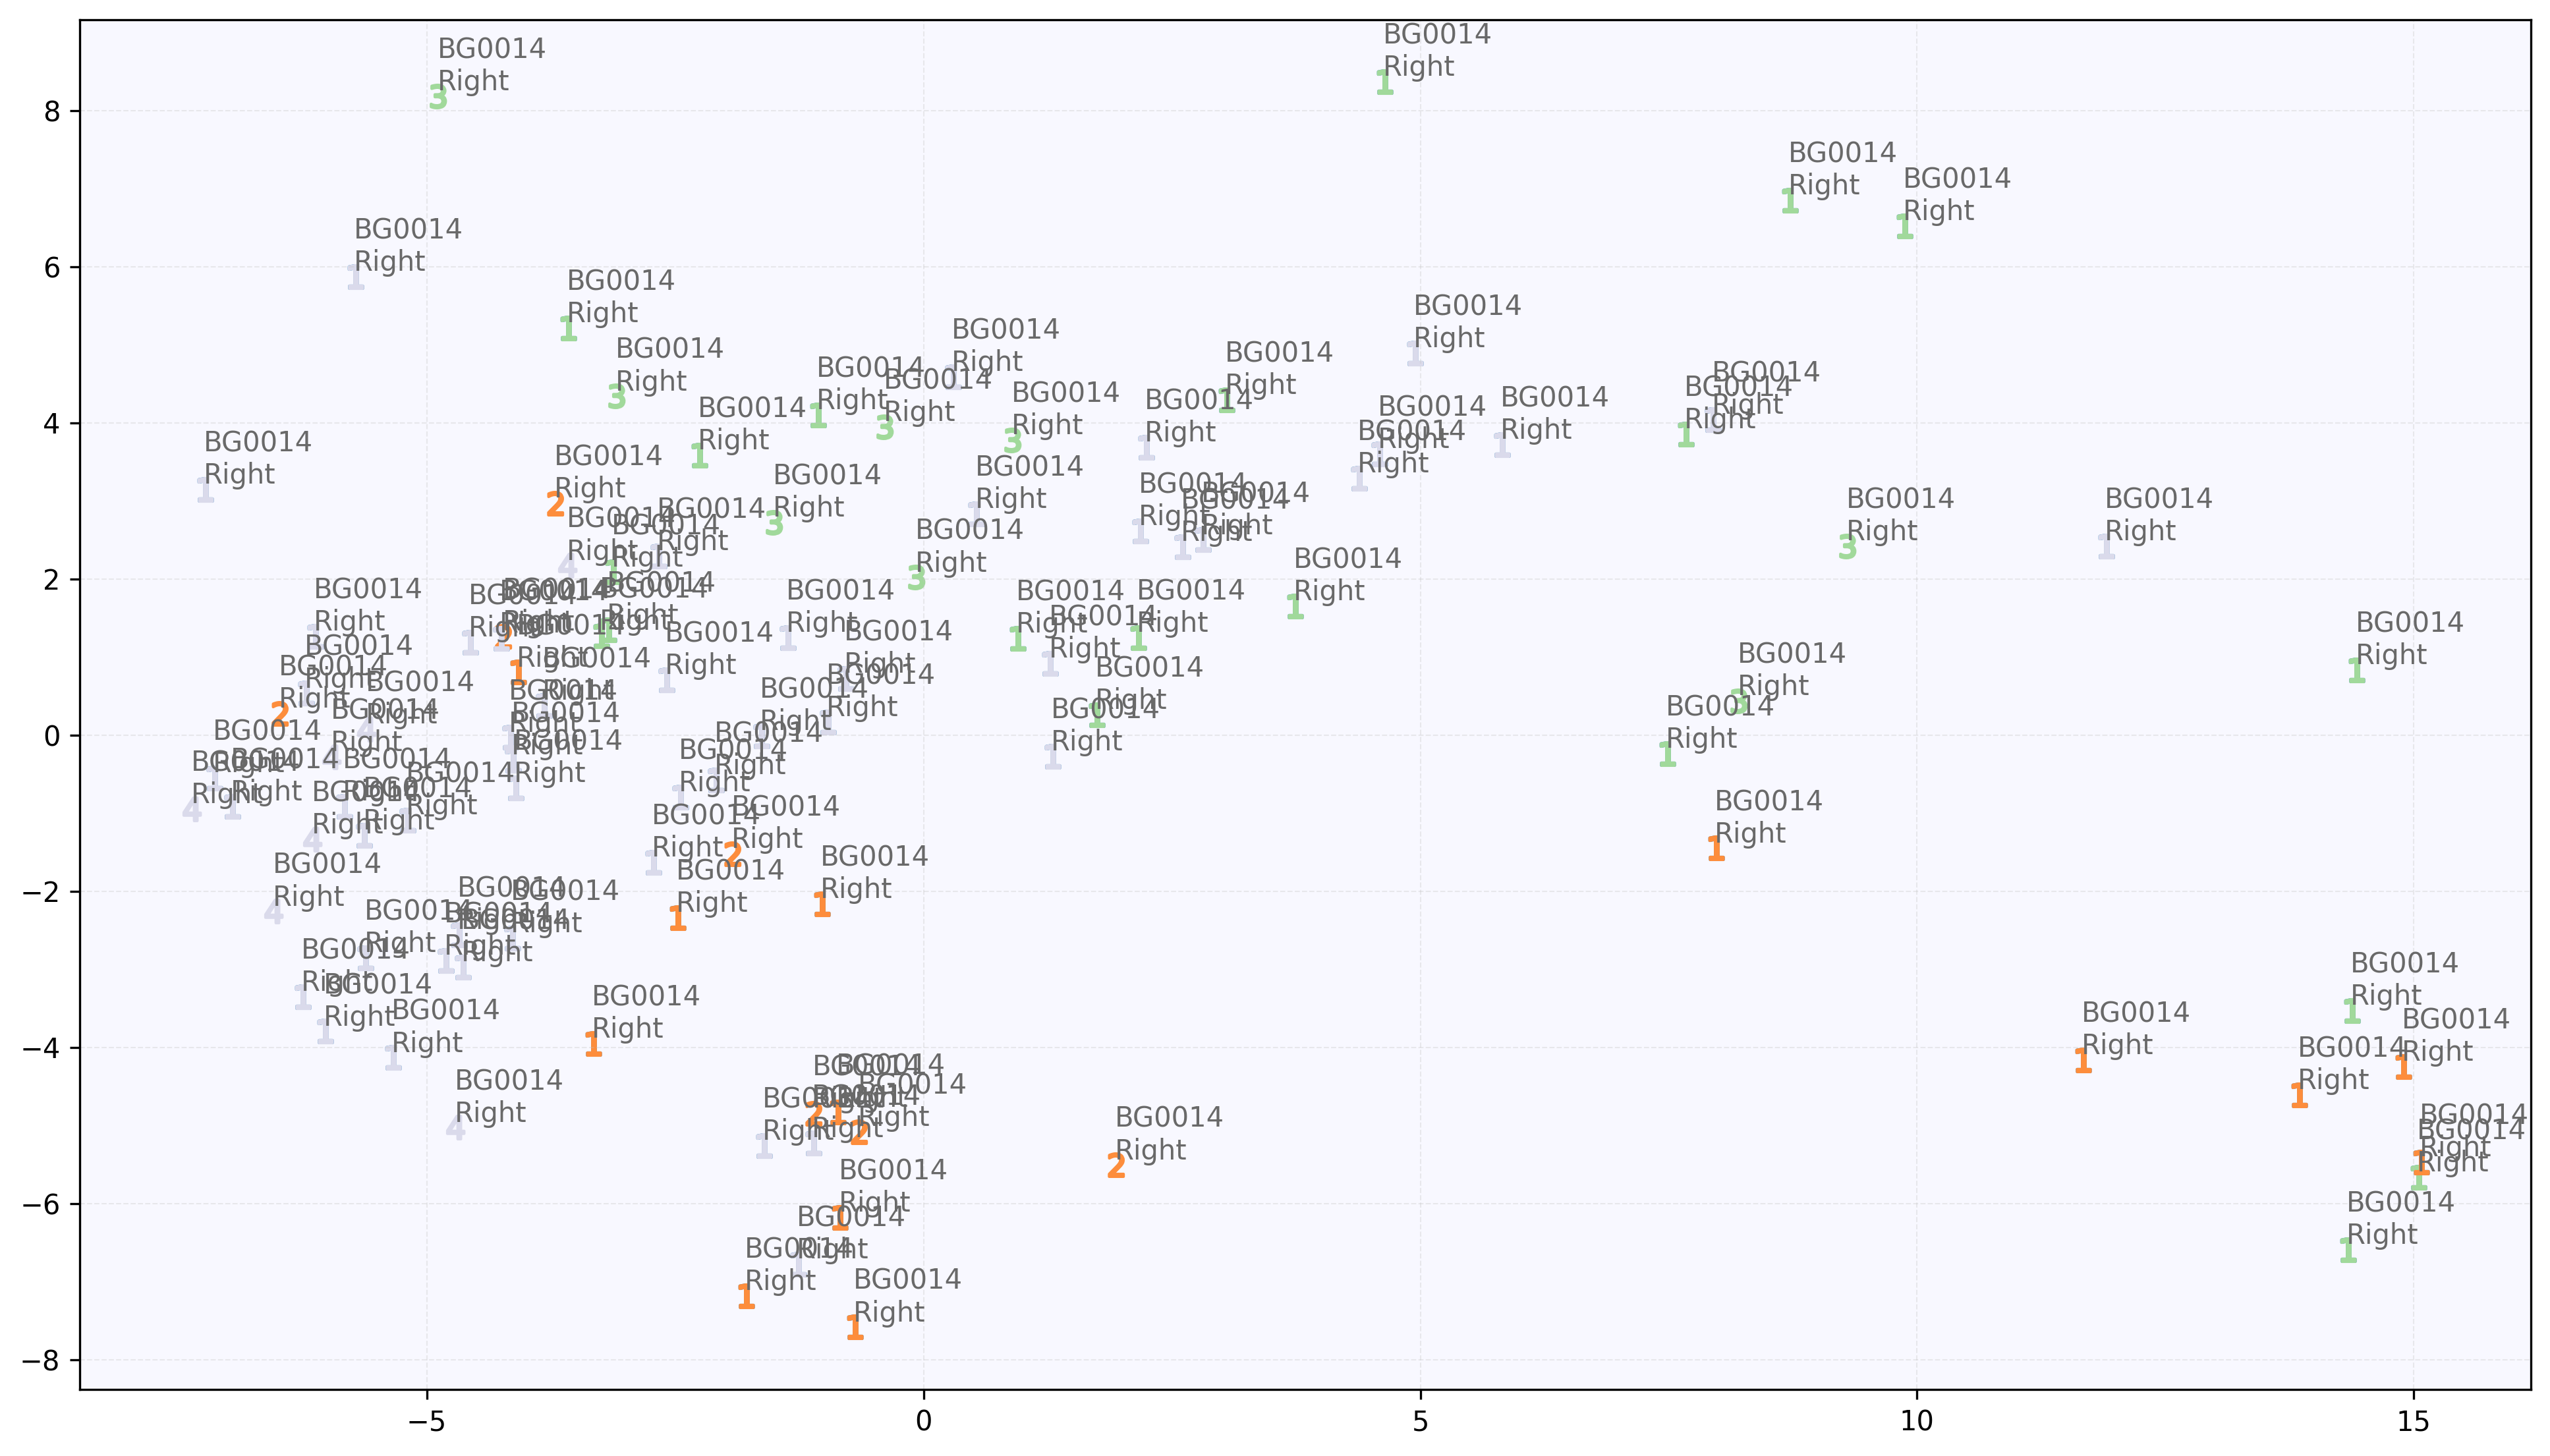

In [34]:
#plotting the results:
cmap=matplotlib.cm.get_cmap("tab20c")
fig = plt.figure(figsize=(16,9), dpi=300)
ax = fig.add_subplot(111)
pc_x = 1
pc_y = 2

clusters = []
c_centroids = []
for i in u_labels:
    ax.scatter(feature[label == i , pc_x] , feature[label == i , pc_y] , 
                label = i, 
                color=cmap((i+0)/(len(u_labels)+0)), 
                s=70,
                marker="${}$".format(i+1))
    cluster = []
    most_typical_distance = 10000
    most_typical_idx = -1
    for j in range(len(feature)):
        if label[j] == i:
            cluster.append(feature[j])
    cluster = np.array(cluster)
    cluster_centroid = np.mean(cluster,axis=0)
    # ax.scatter(cluster_centroid[pc_x], cluster_centroid[pc_y], 
    #            marker="+", 
    #            color = cmap((i+0)/(len(u_labels)+0)),
    #            s = 90)
    clusters.append(cluster)
    c_centroids.append(cluster_centroid)

for j in range(len(feature)):
    ax.text(feature[j, pc_x] , feature[j, pc_y],
            files[i].split("\\")[-1][:-12].split("_")[0] + "\n" + files[i].split("\\")[-1][:-12].split("_")[1],
            color='dimgray',
            va="bottom",
            rotation = 0)
    if label[j] == 0:
        distance_to_1 = np.linalg.norm(feature[j] - c_centroids[1])
        distance_to_2 = np.linalg.norm(feature[j] - c_centroids[2])
        distance_to_3 = np.linalg.norm(feature[j] - c_centroids[3])
        distance_list = [distance_to_1, distance_to_2, distance_to_3]
        min_distance = distance_list.index(min(distance_list))
        # print (min_distance)
        ax.scatter(feature[j, pc_x] , feature[j, pc_y] , 
                color=cmap((min_distance +1)/(len(u_labels)+0)), 
                s=70,
                marker="${}$".format(1))



    
ax.grid(color = 'silver', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax.set_facecolor("ghostwhite")
# plt.legend()
# plt.savefig('cluster.png')
plt.show()
